In [198]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
from src.analysis.themes_genres.genre_theme_analysis import *
from src.utils.helpers import *
from src.utils.constants import *
from src.utils.plots_template import *

In [200]:
movies = convert_csv(pd.read_csv(PREPROCESSED_MOVIES))
movies.head()

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
0,$,NaN,[Russia],"[Drama, Crime, Comedy]",1971,Western,"[Joe Collins, American bank security consultan...","[Dawn Divine, hooker with a heart of gold, cun...",[None],"[Resourcefulness, cleverness, individualism, h...",[None]
1,"$1,000 on the Black","[German, Italian]","[Italy, Germany]",[Western],1966,Eastern,[None],"[Sartana, villainous, oppressive, cruel, arche...","[Johnny Liston, justice, determination, resili...","[Justice, revenge, oppressed vs. oppressor, re...","[Terror, betrayal, familial conflict, crime, r..."
2,"$10,000 Blood Money",NaN,[Russia],"[Drama, Western]",1967,NaN,[None],[None],[None],[None],"[crime, betrayal, revenge, bounty hunter, heis..."
3,"$100,000 for Ringo",[Italian],[Italy],"[Drama, Western]",1965,NaN,[None],[None],[None],[None],"[Western, Civil War, mistaken identity, treasu..."
4,'Anna' i wampir,NaN,[Russia],[Crime],1982,NaN,[None],[None],[None],[None],"[murder mystery, horror, fog, Poland, 1960s]"


# Genre Analysis

## Bar Plots


Start by Plotting the distribution of genres in the initial DataSet

In [201]:
genres_df, common_genres = clean_genre_explode(movies)
genres_df.head()

print("Common genres: ", common_genres)

Common genres:  Index(['Drama', 'Comedy', 'Romance', 'Action', 'Crime', 'Thriller',
       'Adventure', 'Horror', 'Science Fiction', 'Mystery', 'Family', 'War'],
      dtype='object', name='genres')


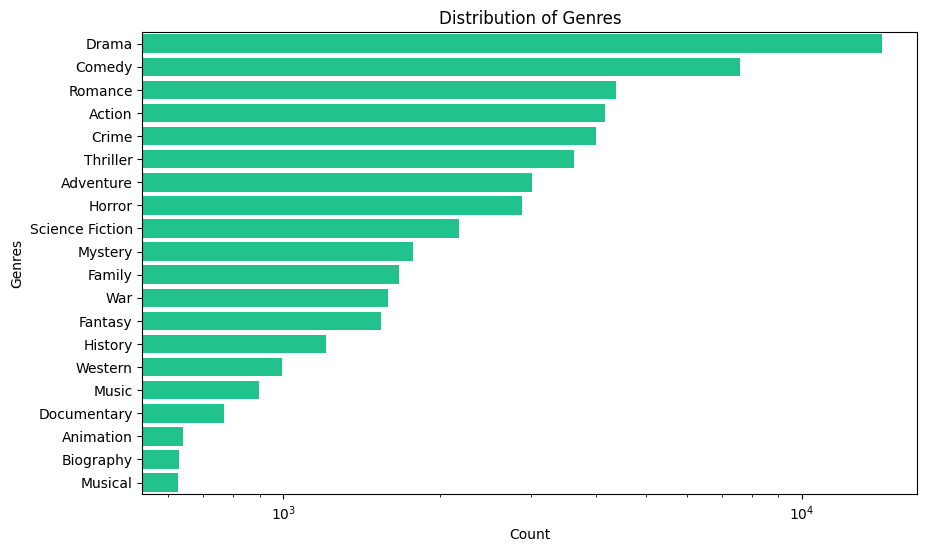

In [202]:
plot_distribution(genres_df, "genres", log_scale=True)

Then Plot the distribution of genres for the movies we are studying (those either in the "Eastern" cold_war_side or the "Western" cold_war_side)

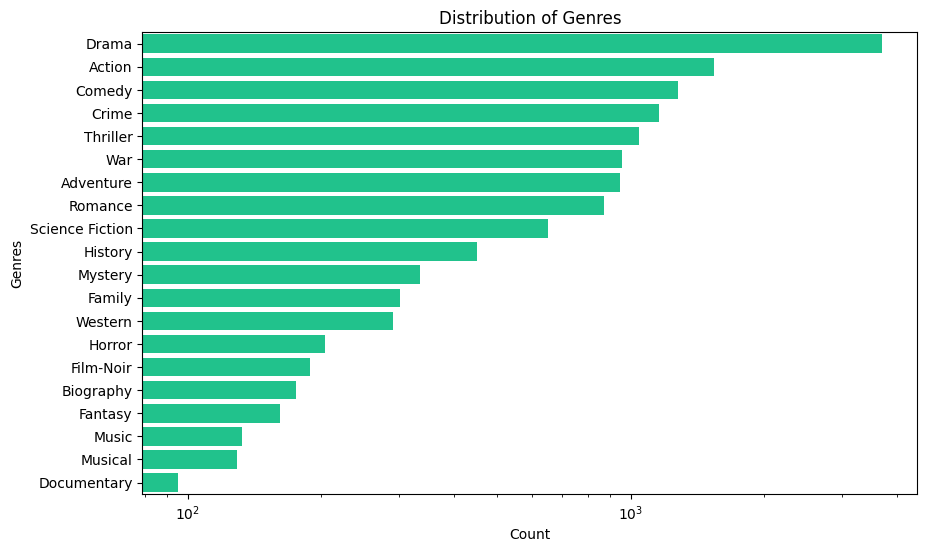

In [203]:
genres_df = genres_df[genres_df["cold_war_side"].isin(["Eastern", "Western"])]
plot_distribution(genres_df, "genres", log_scale=True)

Now plot the distribution of genres per side

In [204]:
western_genre_counts = genres_df[genres_df["cold_war_side"] == "Western"][
    "genres"
].value_counts()
eastern_genre_counts = genres_df[genres_df["cold_war_side"] == "Eastern"][
    "genres"
].value_counts()


fig = plot_side_by_side(
    western_genre_counts.reset_index(),
    eastern_genre_counts.reset_index(),
    x_column="genres",
    y_column="count",
    title="Top 20 Genres",
)

fig.write_html(
    WEB_EXPORT_FOLDER + "top_genres_per_side.html",
    full_html=True,
    include_plotlyjs="cdn",
    config={"responsive": True},
)

Most of the genres appear in the same frequency in both sides. We can instead look at the relative difference between genre count in the eastern side and the western side.

$\textit{relative\_difference} = \frac{\textit{Eastern\_count} - \textit{Western\_count}}{\textit{Eastern\_count} + \textit{Western\_count}}$

In [205]:
genre_comparison = create_comparison_df(western_genre_counts, eastern_genre_counts, 20)
genre_comparison.head(5)

,Western,Eastern,relative_difference,absolute_relative_difference,Eastern_Proportion,Western_Proportion,proportion_relative_difference,absolute_proportion_relative_difference,total
genres,,,,,,,,,
Film-Noir,177,12.0,-0.873016,0.873016,0.217391,1.903021,-0.794954,0.794954,189.0
Western,269,22.0,-0.848797,0.848797,0.398551,2.892162,-0.757772,0.757772,291.0
Tv Movie,25,3.0,-0.785714,0.785714,0.054348,0.268788,-0.663623,0.663623,28.0
Thriller,858,184.0,-0.646833,0.646833,3.333333,9.224815,-0.469136,0.469136,1042.0
Action,1212,327.0,-0.575049,0.575049,5.923913,13.030857,-0.374942,0.374942,1539.0


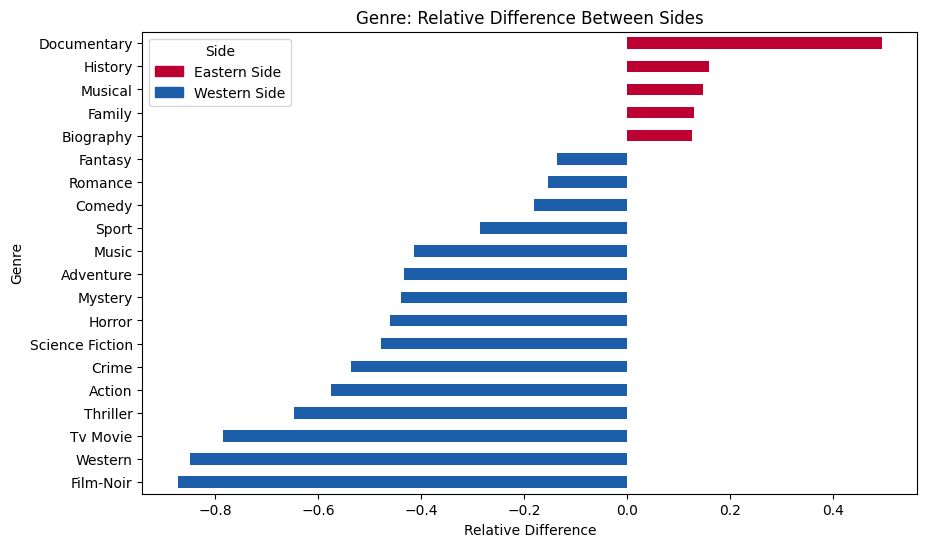

In [206]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=False)

We can look at the relative difference in proportion instead

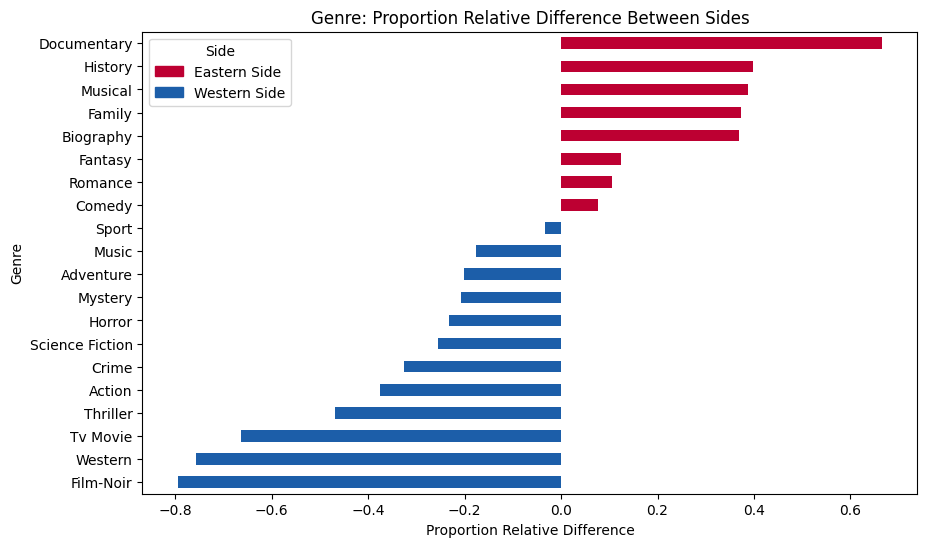

In [207]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=True)

Documentaries and Historical movies appear far more in the eastern bloc, while Thrillers, Actions are more prevalent in the western bloc.
It is not surprising that westerns and film-noirs are a lot more common in the western side.

## Time Series


We can look now how the genre frequency changed over time.

First plot the count every year
Then plot the count each period (either every 5 years or through cold war periods)

In [208]:
western_genres_yearly_counts, eastern_genres_yearly_counts = get_genres_yearly_count(
    genres_df, common_genres
)

In [209]:
plot_interactive_genre_over_time(
    western_genres_yearly_counts, eastern_genres_yearly_counts, common_genres
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function src.analysis.themes_genres.genre_theme_analysis.plot_interactive_genre_over_time.<locals>.interactive_plot(side_genres)>

Either change the Side by interaction


In [210]:
plot_interactive_genre_over_period(genres_df, common_genres)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function src.analysis.themes_genres.genre_theme_analysis.plot_interactive_genre_over_period.<locals>.interactive_plot(side_genres)>

Or make Genres interactive

In [212]:
plot_interactive_side_over_period(genres_df, common_genres)

interactive(children=(Dropdown(description='Genre', index=11, options=('Drama', 'Comedy', 'Romance', 'Action',…

We plot the average number of movies per year because the periods do not have the same duration, and thus any result we would get without averaging first would be misleading.    

Save to HTML:


In [213]:
for genre in common_genres:
    plot_genre_over_periods(genres_df, genre).write_html(
        WEB_EXPORT_FOLDER + f"{genre}_over_period.html",
        full_html=True,
        include_plotlyjs="cdn",
        config={"responsive": True},
    )

We see that war movies begin decreasing in frequency starting from the detente period 

# Theme Analysis

We do similar analysis for themes

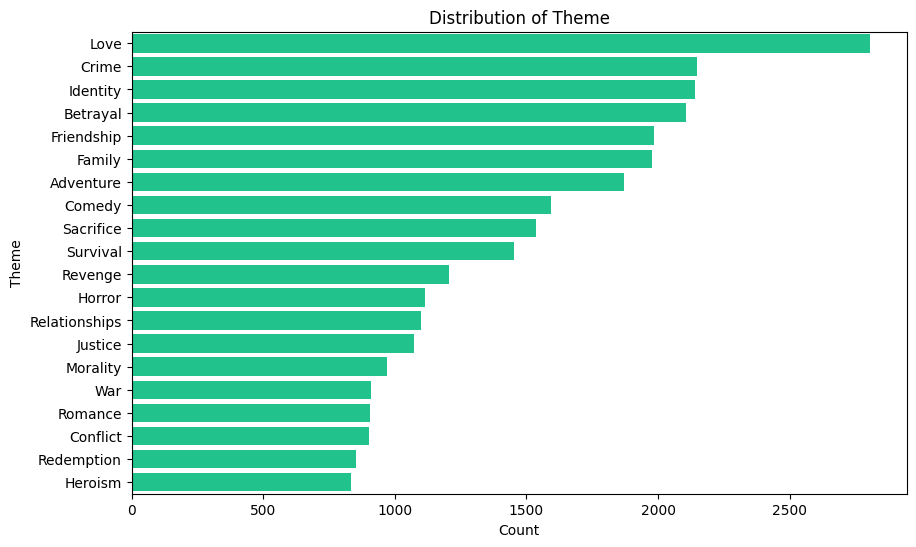

In [214]:
themes_df = (
    movies[["genres", "cold_war_side", "theme", "release_date"]]
    .explode("theme")
    .reset_index()
)
themes_df["theme"] = (
    themes_df["theme"]
    .str.title()
    .str.strip()
    .replace({"Wwii": "World War II", "World War Ii": "World War II"})
)
themes_df = themes_df[themes_df["theme"] != "None"].dropna(subset=["theme", "genres"])

plot_distribution(themes_df, "theme")

In [215]:
western_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Western"]["theme"]
    .explode("theme")
    .value_counts()
)
eastern_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Eastern"]["theme"]
    .explode("theme")
    .value_counts()
)

fig = plot_side_by_side(
    western_theme_counts.reset_index(),
    eastern_theme_counts.reset_index(),
    x_column="theme",
    y_column="count",
    title="Top 20 Themes",
)

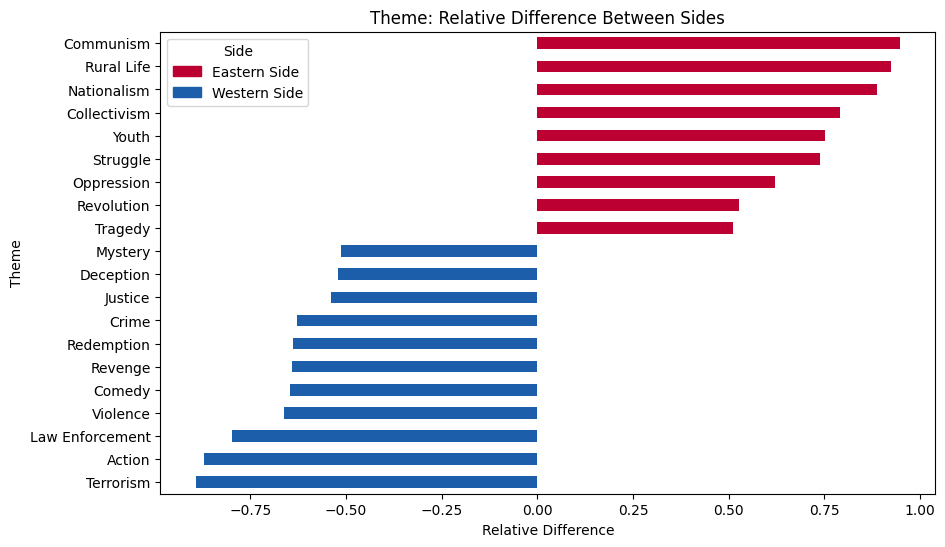

In [216]:
theme_comparison = create_comparison_df(western_theme_counts, eastern_theme_counts, 50)
plot_relative_difference(theme_comparison, "Theme")

Although this already showcases relevant differences, it might be more interesting to look at specific examples. (more in-depth theme analysis will come later)

We can look at themes present in War Movies Specifically

In [217]:
western_war_themes_counts, eastern_war_themes_counts = get_side_war_theme_counts(
    themes_df
)

In [218]:
fig = plot_side_by_side(
    western_war_themes_counts.reset_index(),
    eastern_war_themes_counts.reset_index(),
    x_column="theme",
    y_column="count",
    title="Top 20 Themes for War Movies",
)
fig.write_html(
    WEB_EXPORT_FOLDER + "top_war_themes_per_side.html",
    full_html=True,
    include_plotlyjs="cdn",
    config={"responsive": True},
)

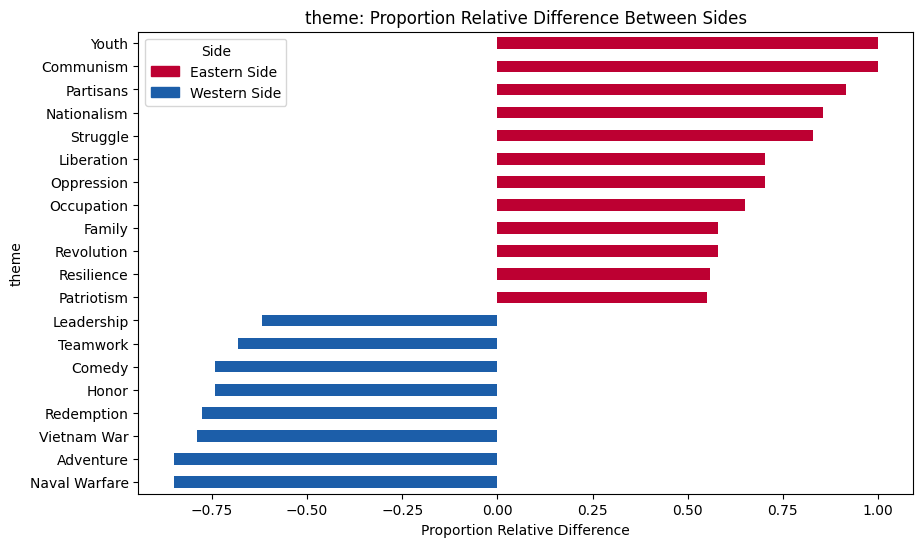

In [219]:
war_theme_comparison = create_comparison_df(
    western_war_themes_counts, eastern_war_themes_counts, 10
)

plot_relative_difference(war_theme_comparison, "theme", prop=True)

Comedy, Adventure more common in the west <br/>
Vietnam War also prevalent

Struggle, Oppression, Resilience more common in the east.


Difference in representation of war movies reveals difference in ideology

Vietnam War Movies Examples

In [220]:
get_vietnam_war_films(movies).sample(5)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
10260,Last Stand at Lang Mei,NaN,[Russia],"[War, Action, Adventure]",1989,Western,"[Captain Fahey, bravery, courage, hero archetype]",[None],"[American soldiers, resilience, camaraderie, p...",[None],"[War, bravery, struggle for survival, Vietnam ..."
3989,Commander,NaN,[Russia],"[War, Action]",1988,Western,"[Commander and his band of freedom fighters, h...","[Vlasov, villainy, oppression, antagonist arch...","[Valor, bravery, individualism, anti-communism]","[Oppression, tyranny, collectivism]","[Action, war, good vs evil, heroism, Vietnam War]"
17122,Strike Commando 2,NaN,[Russia],"[War, Action, Adventure]",1988,Western,"[Seargant Michael Ransom, redemption, heroism,...","[Vic Jenkins, betrayal, corruption, tragic her...",[None],[None],"[Vietnam War, revenge, heroism, betrayal, tort..."
8782,In Country,[English],[Russia],"[War, Romance, Drama, Comedy]",1989,Western,"[Emmett Smith, laid-back, values family and me...",[None],"[Family, memory, resilience, healing]",[None],"[Coming-of-age, Vietnam War, loss, PTSD, famil..."
9684,Kill Zone,[English],"[United States of America, Philippines]","[War, Thriller, Action]",1993,Western,"[American colonel, individualism, hero archetype]",[None],"[Justice, fighting spirit, determination, sacr...",[None],"[War, sacrifice, individualism, Vietnam War, h..."


Comedy / War Movie Examples

In [221]:
get_comedy_war_movies(movies).sample(5)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
22666,The Wackiest Ship in the Army,[English],[United States of America],"[War, Drama, Family, Comedy]",1960,Western,"[Lieutenant Rip Crandall, determined, honorabl...",[None],"[Camaraderie, adventure, humor, teamwork]",[None],"[Comedy, military, misfits, adventure, teamwor..."
24690,"What Did You Do in the War, Daddy?","[German, Italian, English]",[United States of America],"[War, Comedy]",1966,Western,"[Lt. Christian, values friendship and camarade...","[Capitano Fausto Oppo, values tradition and co...","[American soldiers, teamwork, humor, courage, ...","[Italian officers, hospitality, the value of f...","[Comedy, war, absurdity, cultural exchange, hu..."
14430,Privates on Parade,[English],[United Kingdom],"[War, Drama, Comedy]",1983,Western,"[Major Giles Flack, Traditional British values...",[None],"[British army personnel, Comedic camaraderie, ...",[None],"[War, Comedy, Colonialism, Military entertainm..."
24807,Which Way to the Front?,[English],[United States of America],"[War, Comedy]",1970,Western,"[Brendan Byers III, rich, patriotic, resourcef...",[None],"[Patriotism, resourcefulness, individualism, H...",[None],"[Comedy, War, Heroism, patriotism, improvisation]"
12923,No Time for Sergeants,NaN,[Russia],"[War, Comedy]",1958,Western,"[Will Stockdale, values of humor, resilience, ...","[M/Sgt. King, values of mentorship and duty, a...",[None],[None],"[Comedy, military life, underdog, humor, resil..."
